<a href="https://colab.research.google.com/github/yokahealthcare/Anasa-GAN/blob/master/%5BUdemy%5D%20%5BDCGAN%5D%20MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN - MNIST
## Deep Convolutional Generative Adversial Network

## PART 1 : Data Preparation

### Importing libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.11.0'

### Loading dataset MNIST

In [2]:
path = "dataset\mnist.npz"
with np.load(path) as data:
  X_train = data['x_train']
  Y_train = data['y_train']
  X_test = data['x_test']
  Y_test = data['y_test']

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
X_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [5]:
28 * 28

784

### Reshaping the training data (X)
> This must because CNN accept 4-Dimensional Numpy array as input
>
> **STRUCTURE** : (batch_size, height, width, channels)
>
> *Channels can RGB or GRAYSCALE*

In [6]:
X_train = np.reshape(X_train, (60000, 28, 28, 1)).astype("float")

### Scaling the data into range -1 to 1

In [7]:
print("max : {} \t min : {}".format(X_train[0].max(), X_train[0].min()))

max : 255.0 	 min : 0.0


In [8]:
min_value = X_train[0].min()
max_value = X_train[0].max()
# using MinMaxScaler formula and modified it (range : -1 to 1)
X_train = 2 * ((X_train - min_value) / (max_value - min_value)) - 1

In [9]:
print("max : {} \t min : {}".format(X_train[0].max(), X_train[0].min()))

max : 1.0 	 min : -1.0


### Change X_train to batch type variable

In [10]:
buffer_size = X_train.shape[0]   # length of data 60.000 row
batch_size = 256
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [11]:
type(X_train)

tensorflow.python.data.ops.dataset_ops.BatchDataset

## PART 2 : Generator & Discriminator

### Creating build_generator() functions

In [12]:
def build_generator():
  net = tf.keras.Sequential()
  net.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  net.add(layers.BatchNormalization())
  net.add(layers.LeakyReLU())

  net.add(layers.Reshape((7, 7, 256)))

  # 7 x 7 x 128
  net.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = "same", use_bias = False))
  net.add(layers.BatchNormalization())
  net.add(layers.LeakyReLU())

  # 14 x 14 x 64
  net.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), strides = (2,2), padding = "same", use_bias = False))
  net.add(layers.BatchNormalization())
  net.add(layers.LeakyReLU())

   # 28 x 28 x 1
  net.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), strides = (2,2), padding = "same", use_bias = False, activation = "tanh"))

  net.summary()
  return net

In [13]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

### Creating random noise vector

In [14]:
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-1.0069184 , -0.16102263, -0.72600424,  0.20789844, -0.63772255,
        -1.0659212 , -0.14042732,  0.49872246, -0.95532376, -0.5823781 ,
         0.83624387, -0.5850028 , -0.23613784, -0.89135844,  1.8674994 ,
         0.32691145,  0.8364948 , -0.13833733,  1.27057   , -0.8192222 ,
        -0.62953335,  0.6530232 , -0.62709326,  0.88005984, -0.07567638,
         0.19673333,  0.06633167,  0.88189375, -0.37588054,  1.4535233 ,
         1.1959834 ,  0.8834244 , -0.4360591 ,  0.18956782,  1.4399118 ,
        -0.7366036 ,  0.82220477, -1.1244183 ,  0.7855403 ,  0.4427558 ,
        -0.38940284, -0.17569546, -0.49630424, -0.77926433, -0.44958723,
        -2.0045261 , -0.45237884,  1.5963115 ,  1.2934761 ,  0.716046  ,
         0.6486446 ,  0.8916136 , -0.27735114, -0.6321595 , -0.17338613,
        -0.89849126, -0.69054085, -0.2250703 , -1.1904242 ,  0.21273609,
        -1.7408764 ,  0.00248622, -0.53084064, -0.9706435 ,  1.7299806 ,
 

In [15]:
generated_image = generator(noise, training = False)

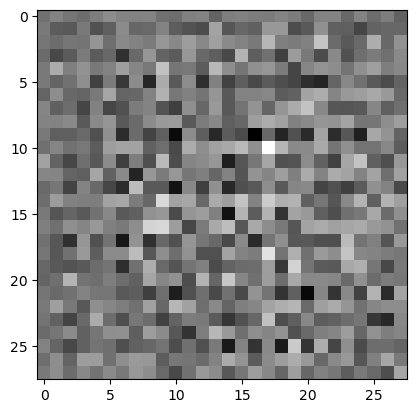

In [16]:
plt.imshow(generated_image[0], cmap="gray")

### Creating build_discriminator()

In [23]:
def build_discriminator():
    net = tf.keras.Sequential()
    
    # 14 x 14 x 64
    net.add(layers.Conv2D(filters=64, strides=(2,2), kernel_size=(5,5), padding="same", input_shape=(28,28,1)))
    net.add(layers.LeakyReLU())
    net.add(layers.Dropout(0.3))
    
    # 7 x 7 x 128
    net.add(layers.Conv2D(filters=128, strides=(2,2), kernel_size=(5,5), padding="same"))
    net.add(layers.LeakyReLU())
    net.add(layers.Dropout(0.3))
    
    # flatten
    net.add(layers.Flatten())
    net.add(layers.Dense(1, activation="sigmoid"))
    
    net.summary()
    return net

In [24]:
discriminator = build_discriminator()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

### Testing the discriminator using the generated image
> The result is 49.99% sure that is fake
>
> but this discriminator still confuse, which is real nor fake. **we must do training**

In [25]:
discriminator(generated_image, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4999584]], dtype=float32)>